<a href="https://colab.research.google.com/github/HerbertMariano/time-series-forecasting/blob/main/mancha_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     2820 non-null   object 
 1   Sunspots  2820 non-null   float64
dtypes: float64(1), object(1)
memory usage: 44.2+ KB


In [5]:
df.isna().sum()

Month       0
Sunspots    0
dtype: int64

In [6]:
df.sort_values('Month',inplace=True)

In [7]:
df['Month'] = pd.to_datetime(df['Month'])

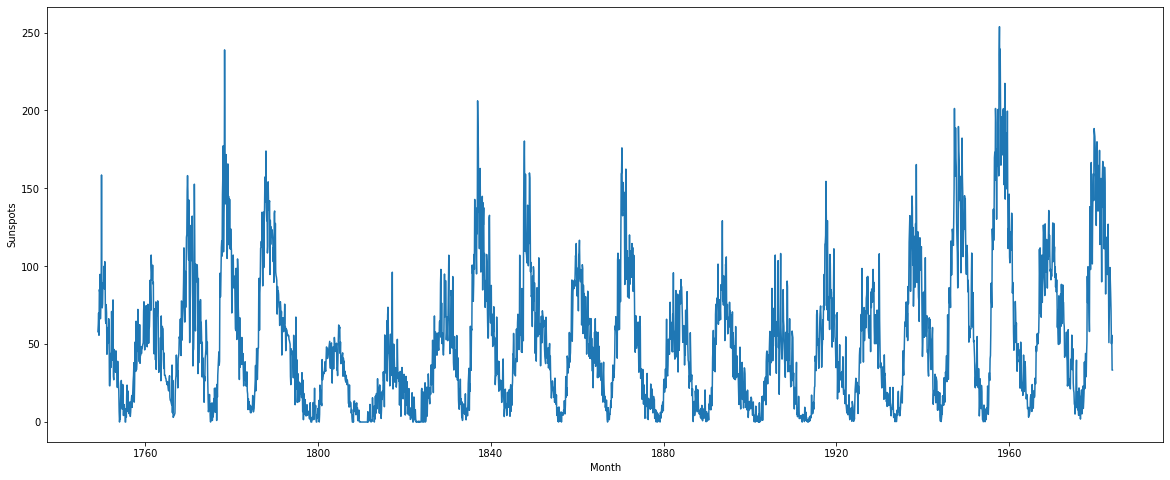

In [8]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='Month',y='Sunspots')

In [9]:
model = auto_arima(df['Sunspots'].values,seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
params = model.get_params()
print(params)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=31.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=24040.854, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=23776.406, Time=1.88 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=23612.819, Time=4.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=24038.855, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=23616.338, Time=1.73 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=23613.432, Time=10.86 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=23612.390, Time=17.65 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=23611.102, Time=14.48 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=36.54 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=23610.776, Time=13.62 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=23612.220, Time=5.97 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=23613.163, Time=1.86 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=24029.632, Time=10.44 sec
 ARIMA(1,1

In [10]:
sarimax = SARIMAX(endog=df['Sunspots'].values,order=params['order'],seasonal_order=params['seasonal_order']).fit()
yhat = sarimax.predict()

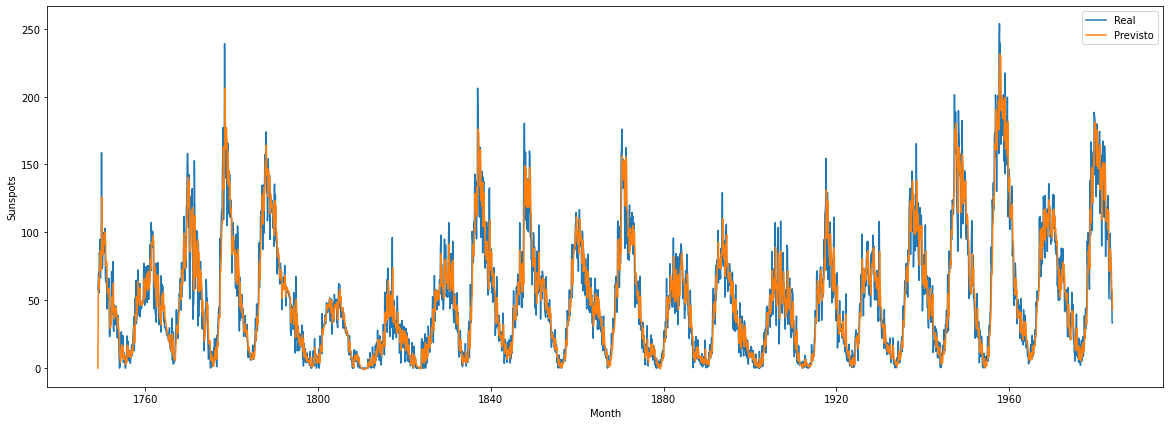

In [11]:
plt.figure(figsize=(20,7))
sns.lineplot(data=df,x='Month',y='Sunspots',label='Real')
sns.lineplot(x=df['Month'],y=yhat,label='Previsto')

In [12]:
def partition_dataframe(df, input_days, target_days):
    data = df.values
    input_data = []
    target_data = []
    for i in range(len(data) - input_days - target_days + 1):
        input_data.append(data[i:i+input_days, 1])
        target_data.append(data[i+input_days:i+input_days+target_days, 1])
    return np.array(input_data), np.array(target_data)

In [20]:
y

array([[73.3, 75.9],
       [75.9, 89.2],
       [89.2, 88.3],
       ...,
       [50.3, 55.8],
       [55.8, 33.3],
       [33.3, 33.4]], dtype=object)

In [13]:
X,y = partition_dataframe(df=df,input_days=12,target_days=2)

In [18]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100,learning_rate=0.1,max_depht=10)
model.fit(X,y)


[04:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depht=10)

In [25]:
model.predict(X).shape

(2807,)